In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! unzip -q "drive/My Drive/Dataset_Upload/Dataset"

In [0]:
# Import dependancies
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
from matplotlib import style
import os
import h5py
import random
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style = "whitegrid", color_codes = True)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
print(os.listdir("Dataset"))

['Test', 'Train']


In [0]:
# Set Image Dimensions
IMAGE_WIDTH = 450
IMAGE_HEIGHT = 450

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [0]:
# Label images in Train set
filenames = os.listdir("Dataset/Train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    
    if category == 'all':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({'filename' : filenames, 'category' : categories})

In [0]:
df.head()

,filename,category
0,all.UID_26_14_1_all.bmp,1
1,hem.0_UID_H23_12_5_hem.bmp,0
2,all.UID_46_31_3_all.bmp,1
3,all.UID_74_3_1_all.bmp,1
4,all.UID_47_14_5_all.bmp,1


In [0]:
df.tail()

,filename,category
19995,hem.1_UID_H20_8_3_hem.bmp,0
19996,all.UID_30_28_7_all.bmp,1
19997,all.UID_14_37_4_all.bmp,1
19998,all.UID_38_22_6_all.bmp,1
19999,all.0_UID_37_16_1_all.bmp,1


Training set contains: 20000 samples


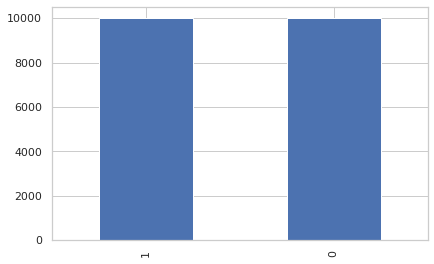

In [0]:
df['category'].value_counts().plot.bar()
print("Training set contains:", len(df), "samples")

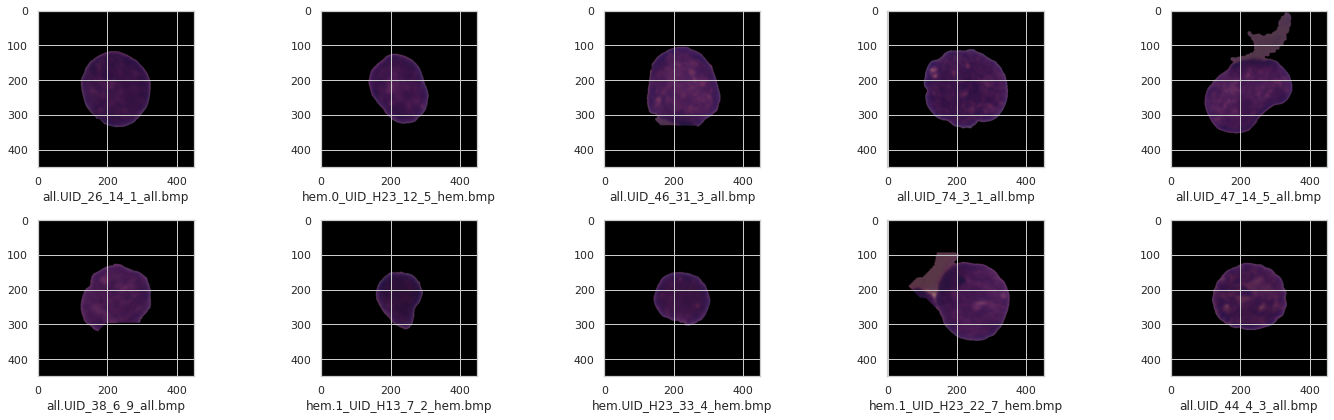

In [0]:
sample_train = df.head(10)
sample_train.head()

plt.figure(figsize = (20, 6))

for index, row in sample_train.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Dataset/Train/" + filename, target_size = IMAGE_SIZE)
    plt.subplot(2, 5, index + 1)
    plt.imshow(img)
    plt.xlabel(filename)
    
plt.tight_layout()
plt.show()

In [0]:
df["category"] = df["category"].replace({0 : 'hem', 1 : 'all'})

In [0]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42)

train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

Training set contains 16000 samples


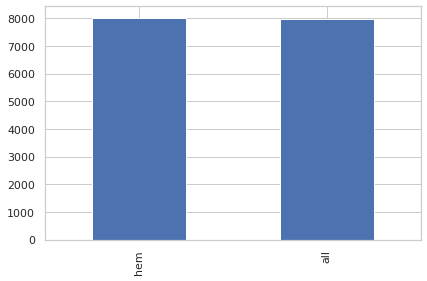

In [0]:
train_df['category'].value_counts().plot.bar()
print("Training set contains", len(train_df), "samples")

In [0]:
batch_size = 32

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Dataset/Train",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 16000 validated image filenames belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
validation_generator = train_datagen.flow_from_dataframe(
    validate_df,
    "Dataset/Train",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 4000 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


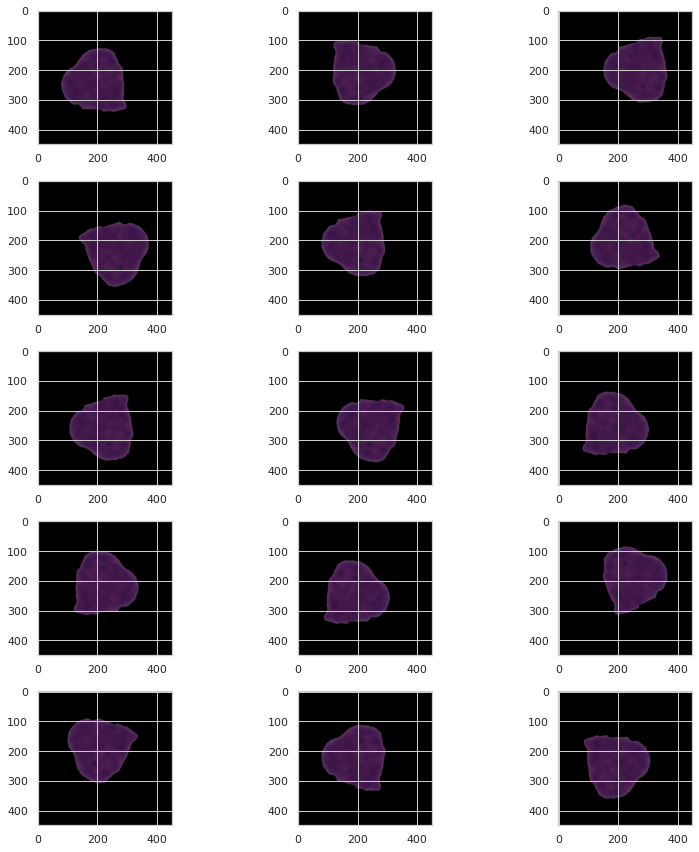

In [0]:
example_df = train_df.sample(n = 1).reset_index(drop = True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "Dataset/Train",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

plt.figure(figsize = (12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i + 1)
    
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [0]:
model = load_model("drive/My Drive/Dataset_Upload/allnet1_1.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 450, 450, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 256)     147712    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 384)       885120    
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 50, 384)       1536      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 384)      

In [0]:
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

In [0]:
epochs = 3

In [0]:
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/3
500/500 [==============================] - 996s 2s/step - loss: 0.1819 - accuracy: 0.9259 - val_loss: 0.2441 - val_accuracy: 0.9158
Epoch 2/3
500/500 [==============================] - 973s 2s/step - loss: 0.1806 - accuracy: 0.9283 - val_loss: 0.3256 - val_accuracy: 0.8925
Epoch 3/3
500/500 [==============================] - 968s 2s/step - loss: 0.1785 - accuracy: 0.9280 - val_loss: 0.4141 - val_accuracy: 0.9392


### Prepare the Test Set

In [0]:
test_filenames = os.listdir("Dataset/Test")

random.shuffle(test_filenames)

In [0]:
test_df = pd.DataFrame({'filename' : test_filenames})
nb_samples = test_df.shape[0]

In [0]:
# Label images in Test set
test_categories = []

for test_filename in test_filenames:
    test_category = test_filename.split('.')[0]
    
    if test_category == 'all':
        test_categories.append(1)
    else:
        test_categories.append(0)
        
test_df = pd.DataFrame({'filename' : test_filenames, 'category' : test_categories})

In [0]:
test_df.head()

,filename,category
0,all.0_UID_17_17_1_all.bmp,1
1,all.0_UID_24_30_3_all.bmp,1
2,all.0_UID_25_23_2_all.bmp,1
3,all.0_UID_21_12_2_all.bmp,1
4,hem.0_UID_H2_25_1_hem.bmp,0


In [0]:
test_df.tail()

,filename,category
5995,hem.0_UID_H14_21_9_hem.bmp,0
5996,all.0_UID_26_3_4_all.bmp,1
5997,hem.0_UID_H14_4_3_hem.bmp,0
5998,hem.0_UID_H10_139_3_hem.bmp,0
5999,all.0_UID_30_14_6_all.bmp,1


In [0]:
test_labels = test_df[["category"]].to_numpy()
test_labels

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [0]:
test_labels = np.transpose(test_labels)
test_labels[0]
true = np.reshape(test_labels, (6000, ))
true

array([1, 1, 1, ..., 0, 0, 1])

In [0]:
true.shape

(6000,)

In [0]:
test_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "Dataset/Test",
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 6000 validated image filenames.


### Predict class on the images in the Test set

In [0]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples / batch_size), verbose = 1)

188/188 [==============================] - 286s 2s/step


In [0]:
test_df['category'] = np.argmax(predict, axis = -1)

In [0]:
label_map = dict((v, k) for k, v in train_generator.class_indices.items())

test_df['category'] = test_df['category'].replace(label_map)

In [0]:
test_df['category'] = test_df['category'].replace({'all' : 1, 'hem' : 0})

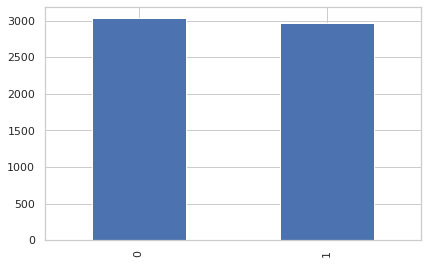

In [0]:
test_df['category'].value_counts().plot.bar()

In [0]:
print(test_df['category'].value_counts())

0    3035
1    2965
Name: category, dtype: int64


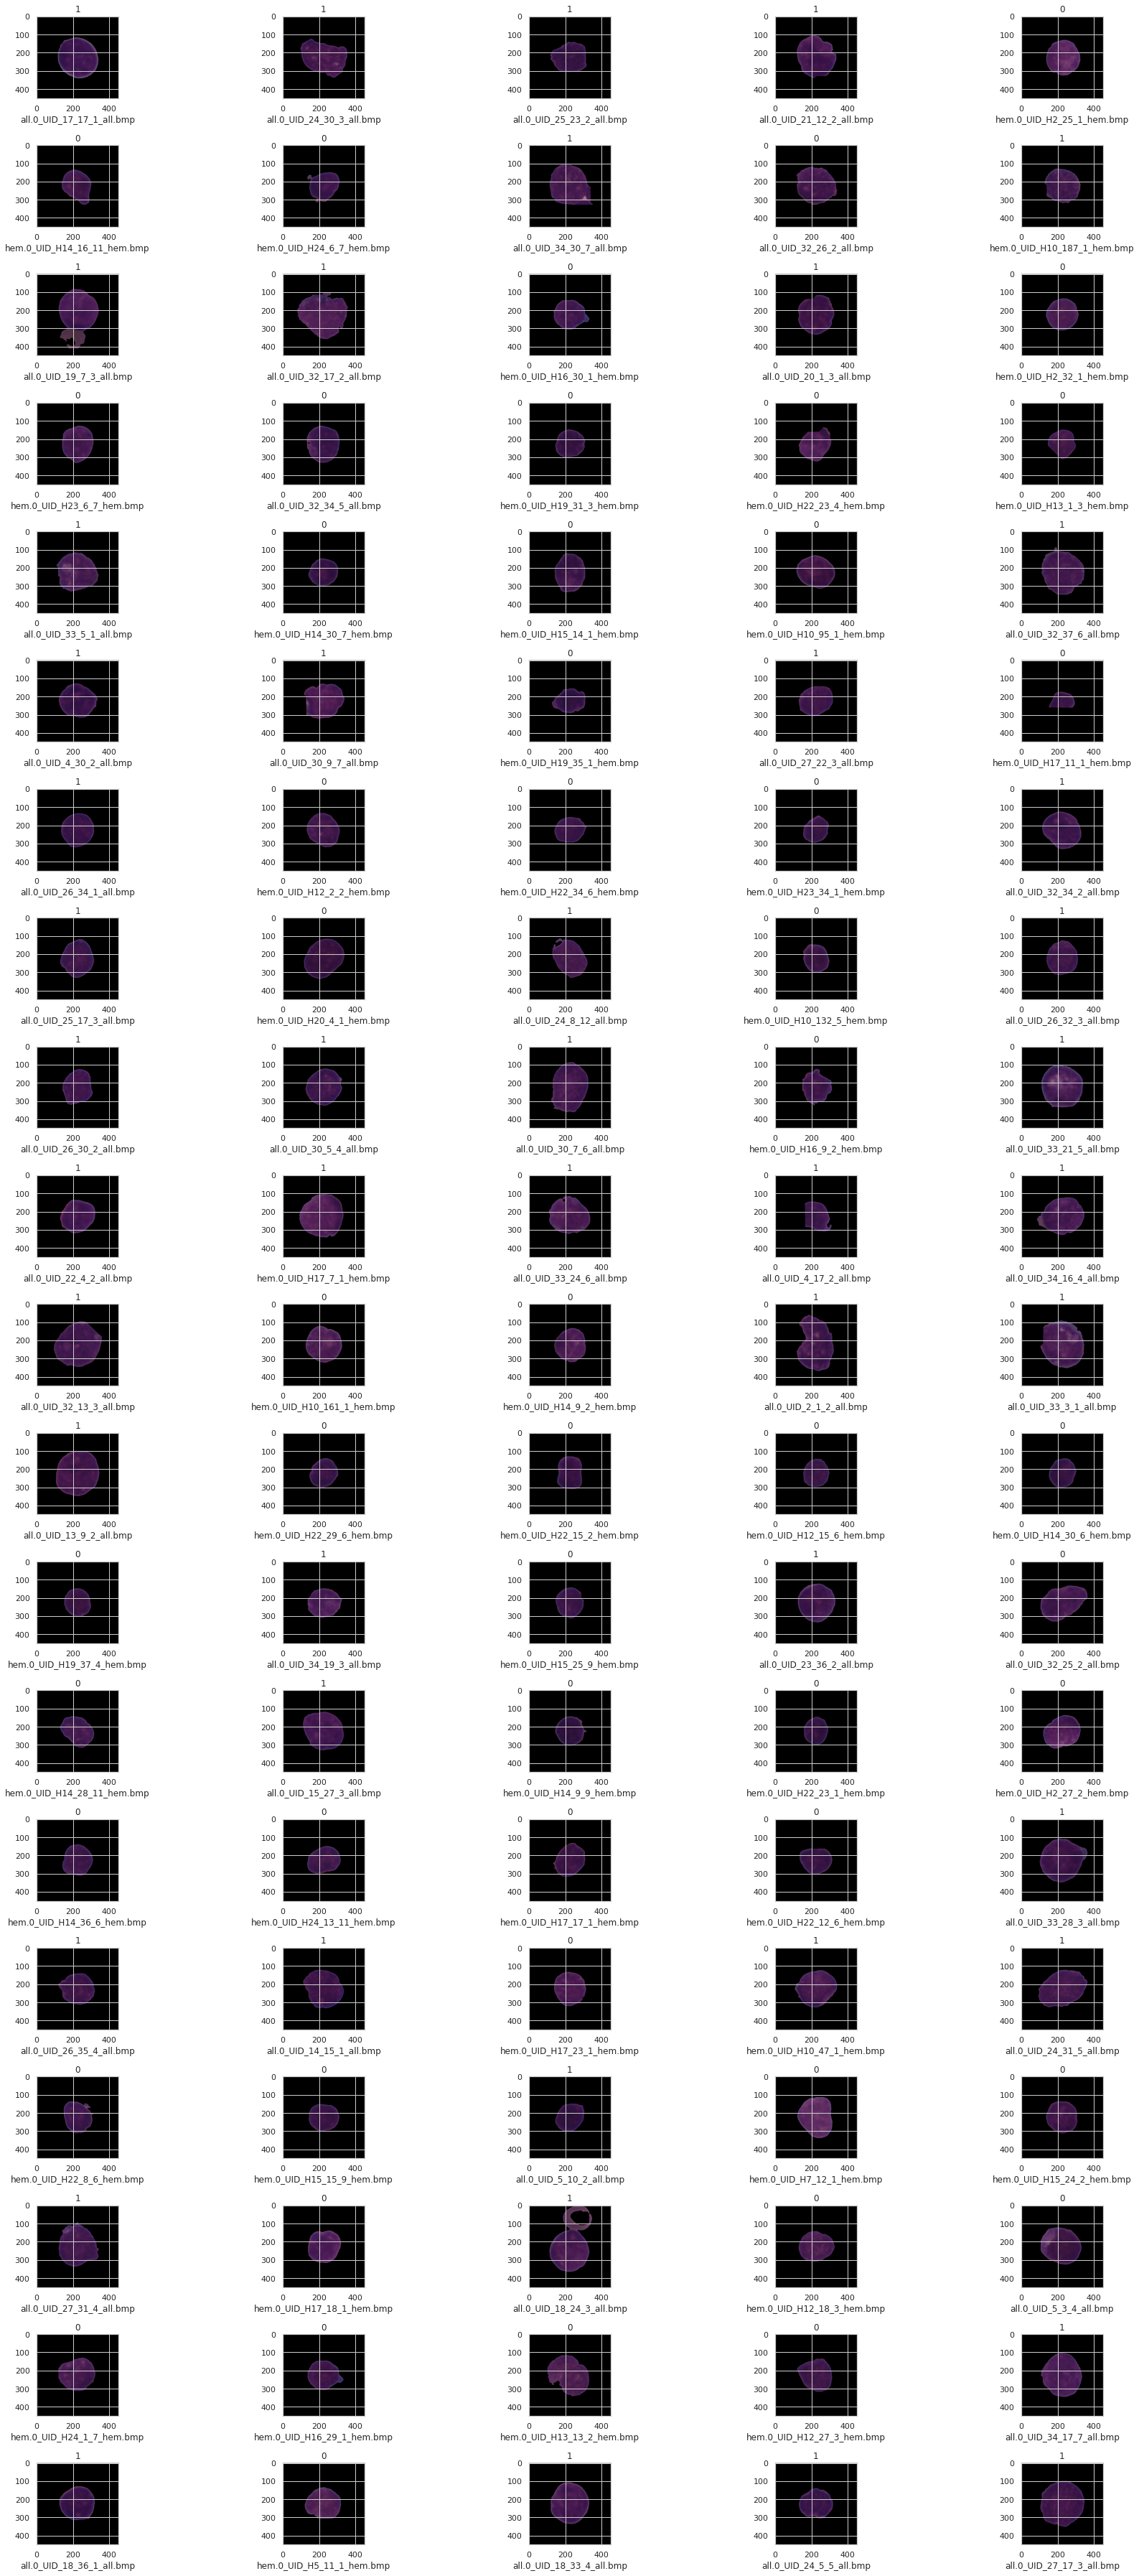

In [0]:
sample_test = test_df.head(6000)
sample_test.head()
plt.figure(figsize = (25, 500))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Dataset/Test/" + filename, target_size = IMAGE_SIZE)
    plt.subplot(1200, 5, index + 1)
    plt.imshow(img)
    plt.xlabel(filename)
    plt.title("{}".format(category))
plt.tight_layout()
plt.show()

In [0]:
pred_labels = np.argmax(predict, axis=1)
np.array(pred_labels)
prediction = np.reshape(pred_labels, (6000, ))

In [0]:
prediction.shape

(6000,)

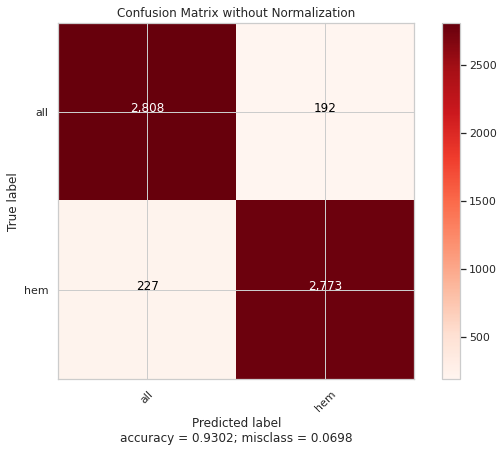

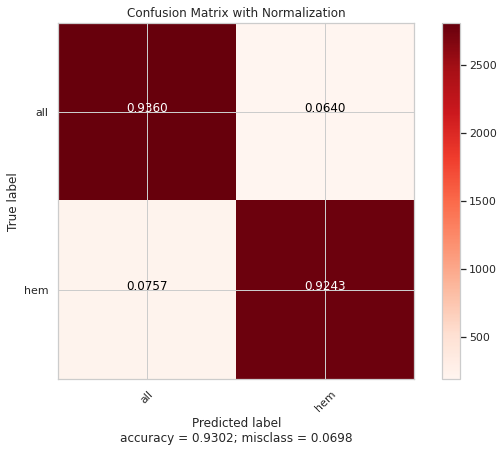

In [0]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Confusion matrix',
                          cmap = None,
                          normalize = True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.show()

img1 = plot_confusion_matrix(cm = np.array([[2808,  192],
                                           [227,  2773]]), 
                            normalize = False,
                            target_names = ['all', 'hem'],
                            title = "Confusion Matrix without Normalization")

print("\n\n")

img2 = plot_confusion_matrix(cm = np.array([[2808,  192],
                                            [227,  2773]]), 
                            normalize = True,
                            target_names = ['all', 'hem'],
                            title = "Confusion Matrix with Normalization")

In [0]:
TP = 2808
FP = 192
TN = 2773
FN = 227

# Calculate Accuracy
acc = ((TP + TN) / (TP + TN + FP + FN)) * 100
print("The accuracy is :", round(acc, 2), "%")

# Calculate Precision
precision = TP / (TP + FP) * 100
print("The precision is : ", round(precision, 2), "%")

# Calculate Recall
recall = TP / (TP + FN) * 100
print("The recall is : ", round(recall, 2), "%")

# Calculate F1 score
F1 = 2 * ((precision * recall) / (precision + recall)) / 100
print("The F1 score is : ", round(F1, 2))

The accuracy is : 93.02 %
The precision is :  93.6 %
The recall is :  92.52 %
The F1 score is :  0.93
